# Analyse des données fournies par Assur'Aimant

Dans le but de réaliser une régression linéaire pour prédire "rapidement" une valeur de la colonne "charges",
analysons l'influence des valeurs de chaque autre colonne sur celle ci.

In [18]:
import pandas as pd
df = pd.read_csv("dataset.csv")
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [19]:
def get_region_code(region :str) -> int :
    match region : 
        case "northeast" : return 1 
        case "northwest" : return 2
        case "southwest" : return 3
        case "southeast" : return 4
        case _ : raise Exception("It should not happen")

dataframe_exploitable = df.copy()
dataframe_exploitable["sex"] = df["sex"].apply( lambda x : 1 if x == "male" else 0)
dataframe_exploitable["smoker"] = df["smoker"].apply( lambda x : 1 if x == "yes" else 0)
dataframe_exploitable["region"] = df["region"].apply( lambda x : get_region_code(x))
dfe = dataframe_exploitable
dfe.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,3,16884.9240
1,18,1,33.77,1,0,4,1725.5523


# 1. Analyse univariée
D'abord chaque colonne séparément


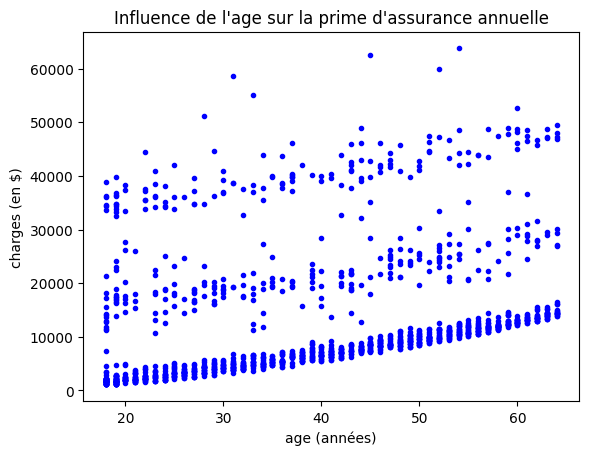

In [33]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array(dfe, dtype=float)

#Colonne age
plt.xlabel("age (années)") # index = 0
plt.ylabel("charges (en $)") # index = 6
plt.plot(data[:,0], data[:,6], 'b.')
plt.title("Influence de l'age sur la prime d'assurance annuelle")
plt.show()

La prime d'assurance ( valeur de la colonne "charges") croit globalement avec l'age.

La relation ${charges} = f({age})$ semble linéaire : $${charges} = {A} \times {age} + {B} $$
ou peut être légèrement quadratique : $${charges} = {A} \times {age^2}  + {B} \times {age} + {C} $$


On peut donc choisir la colonne age comme un bon indicateur de base de la régression linéaire.

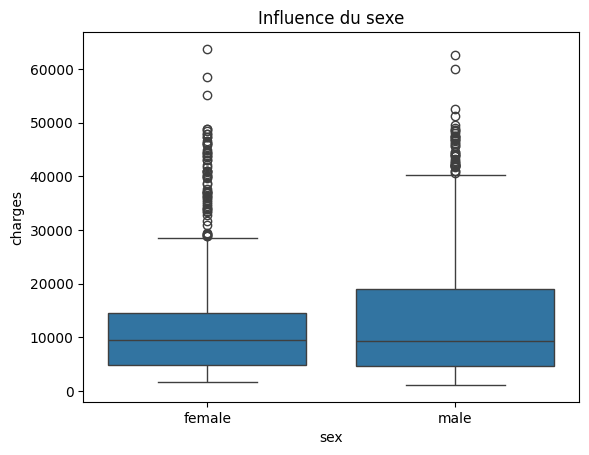

In [ ]:
import seaborn as sns

#Colonne sex ( index = 1 )
sns.boxplot(x=df['sex'], y=df['charges']) 
plt.title('Influence du sexe')
plt.show()




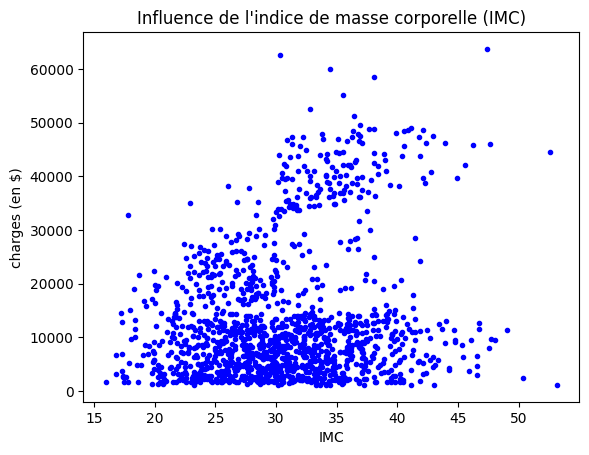

In [39]:
#Colonne bmi
plt.xlabel("IMC") # index = 2
plt.ylabel("charges (en $)") # index = 6
plt.plot(data[:,2], data[:,6], 'b.')
plt.title("Influence de l'indice de masse corporelle (IMC)")
plt.show()

In [ ]:
#Colonne children
sns.boxplot(x=df['children'], y=df['charges'])
plt.title("Influence du nombre d'enfants")
plt.show()

#Colonne smoker
sns.boxplot(x=df['sex'], y=df['charges'])
plt.title("Influence d'être fumeur ou non fumeur")
plt.show()

#Colonne region
sns.boxplot(x=df['region'], y=df['charges'])
plt.title("Influence de la région")
plt.show()




# 2. Analyse bivariée
En croisant les colonnes
    